#Klasifikasi Jamur Menggunakan Genetic Algorithm

- Aldi Oktaviana Hidayat (G64180005)
- Muhammad Naufal Abdillah (G64180016)
- Muhammad Dwiki Ramdhani (G64180032)
- Muhammad Thareeq Izzulhaq (G64180041)
- Muhammad Rayhan Adyatma (G64180064)

##Import Library, dataset, dan fungsi-fungsi:

###Library:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files, drive

warnings.filterwarnings('ignore')
np.random.seed(69420)
random.seed(69420)

###Memasukkan Dataset:

In [ ]:
#Jika mengupload file dari local
files.upload()

Saving mushrooms.csv to mushrooms.csv


{'mushrooms.csv': b'class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat\np,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u\ne,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g\ne,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m\np,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u\ne,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g\ne,x,y,y,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,k,n,g\ne,b,s,w,t,a,f,c,b,g,e,c,s,s,w,w,p,w,o,p,k,n,m\ne,b,y,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,s,m\np,x,y,w,t,p,f,c,n,p,e,e,s,s,w,w,p,w,o,p,k,v,g\ne,b,s,y,t,a,f,c,b,g,e,c,s,s,w,w,p,w,o,p,k,s,m\ne,x,y,y,t,l,f,c,b,g,e,c,s,s,w,w,p,w,o,p,n,n,g\ne,x,y,y,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,k,s,m\ne,b,s,y,t,a,f,c,b,w,e,c,s,s,w,w,p,w,o,p,n,s,g\np,x,y,w,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,n,v,u\ne,x,f,n,f,n,f,w,b,n,t

In [ ]:
#Jika file ada di google drive (dataset disimpan pada direktori "Semester 6/Sisdas/data/mushrooms.csv")
drive.mount('/content/drive')

###Fungsi-Fungsi:

In [ ]:
########################

def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))
    
    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions
    
def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

def mating_pool(pop, fitness, num_parents):
    print("pop shape")
    print(pop.shape)
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1]/2)

    print("looping berapa kali")
    print(offspring_size[0])

    print("parent shape")
    print(parents.shape)

    for k in range(offspring_size[0]):
        # 0, 1 | 1, 2 | 2, 3 | 3, 0

        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        
    return offspring


def mutation(offspring_crossover, mutation_percent):
    num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
    
    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1) # kenapa uniform ? biar ga dapet nilai pengurangan/penjumlahan yang besar
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    
    return offspring_crossover

##############################

In [ ]:
np.random.uniform(-1.0, 1.0, 1)

array([-0.6041328])

###Membaca dataset:

In [ ]:
#Jika file diuload dari local
df = pd.read_csv('/content/mushrooms.csv', na_values="?")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [ ]:
#Jika file berada di drive
df = pd.read_csv('/content/drive/MyDrive/Semester 6/Sisdas/data/mushrooms.csv', na_values="?")
df.head

##Pra-proses:

In [ ]:
#Ambil target
target = df['class']

#Merubah missing value menjadi modus
df['stalk-root'].fillna(df['stalk-root'].mode()[0], inplace=True)

#Merubah data kategorik kedalam bentuk angka
encoder = LabelEncoder()
df_encoded = df.iloc[:, 1:]
cols = df_encoded.columns.values
for col in cols:
    # print(df[col].unique())
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

target_encoded = encoder.fit_transform(target)

df_encoded.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,2,2,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,1,2,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,1,2,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,2,2,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,2,2,2,7,7,0,2,1,0,3,0,1


##Klasifikasi:

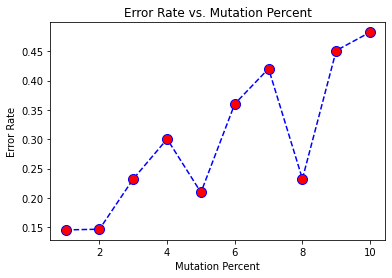

In [ ]:
#Split data train dan test
x_train, x_test, y_train, y_test = train_test_split(df_encoded.to_numpy(), target_encoded, test_size = 0.20, random_state = 42)

#Parameter GA
solution_per_population = 8
num_parents_mating = 4
num_generations = 100

input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

# inisiasi weight
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):
    
    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1, size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

#Parameter penilaian
error_rate = []
accu_uyeh = []
best_outputs = []
accuracies = np.empty(shape=(num_generations))

# Pengujian model
for i in range(1,11):
  mutation_percent = i/10
  
  weights_mat = np.array(initial_weights)
  weights_vector = mat_to_vector(weights_mat)

  accuracies = np.empty(shape=(num_generations))
  for generation in tqdm(range(num_generations), desc="Processing mutation_percent = " + str(i/10), leave=False):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)
    
    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)
    
    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation
  
  weights_mat = vector_to_mat(weights_vector, weights_mat)
  best_weights = weights_mat [0, :]
  acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
  error_rate.append(np.mean(predictions != y_train))
  accu_uyeh.append(acc)

#Plot
xDex = []
for i in range(1,11):
  xDex.append(i/10)

plt.plot(xDex, error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Mutation Percent')
plt.xlabel('Mutation Percent')
plt.ylabel('Error Rate')
plt.show()

In [ ]:
(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1])

(4, 11136)

In [ ]:
weights_vector.shape

(8, 11136)

###Membuat model dengan mutation_percent terbaik:

In [ ]:
#Split data train dan test
x_train, x_test, y_train, y_test = train_test_split(df_encoded.to_numpy(), target_encoded, test_size = 0.20, random_state = 42)

# Buat model dengan mutation_percent 0.1
solution_per_population = 8
num_parents_mating = 4
num_generations = 100
mutation_percent = 0.1

input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

# inisiasi weight
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):
    
    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1,size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

# training
for generation in tqdm(range(num_generations)):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)
    
    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)
    
    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation
  
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<03:55,  2.37s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)




  2%|▏         | 2/100 [00:04<03:50,  2.35s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)




  3%|▎         | 3/100 [00:06<03:46,  2.34s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


KeyboardInterrupt: ignored

###Plot Fitnes setiap iterasinya:

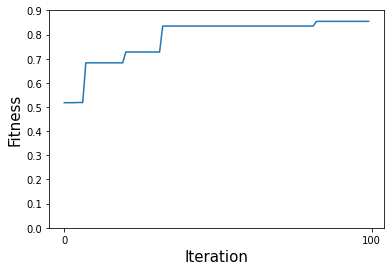

In [ ]:
plt.plot(accuracies)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.xticks(np.arange(0, num_generations+1, 100))
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

###Cunfusion Matrix & Classification Report:

In [ ]:
print(confusion_matrix(y_train,predictions))
print(classification_report(y_train,predictions))

[[2926  439]
 [ 507 2627]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      3365
           1       0.86      0.84      0.85      3134

    accuracy                           0.85      6499
   macro avg       0.85      0.85      0.85      6499
weighted avg       0.85      0.85      0.85      6499



##Prediksi data test

In [ ]:
#Implementasi pada data test
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_test, y_test, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.8547692307692307


###Cunfusion Matrix & Classification Report:

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[738 105]
 [131 651]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       843
           1       0.86      0.83      0.85       782

    accuracy                           0.85      1625
   macro avg       0.86      0.85      0.85      1625
weighted avg       0.85      0.85      0.85      1625

